# Warehouse test

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def generate_map(x_offset, y_offset, width, height, spacing):
    # Define the dimensions of the shelves and the spacing

    # Define the number of shelves
    rows = 6
    cols = 7

    # Create a list to hold the shelf polygons
    shelves = []

    # Generate the shelves with proper spacing
    for i in range(rows):
        for j in range(cols):
            # Calculate the bottom-left corner of the shelf
            x = j * (width + spacing) + x_offset
            y = i * (height + spacing) + y_offset

            # Create the shelf polygon
            shelf = [
                (x, y),
                (x + width, y),
                (x + width, y + height),
                (x, y + height)
            ]

            # Add the shelf to the list
            shelves.append(shelf)
    return shelves

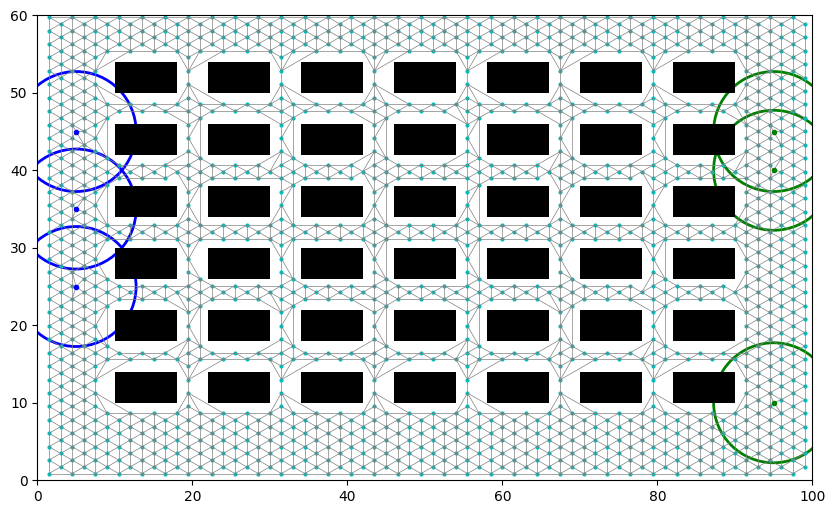

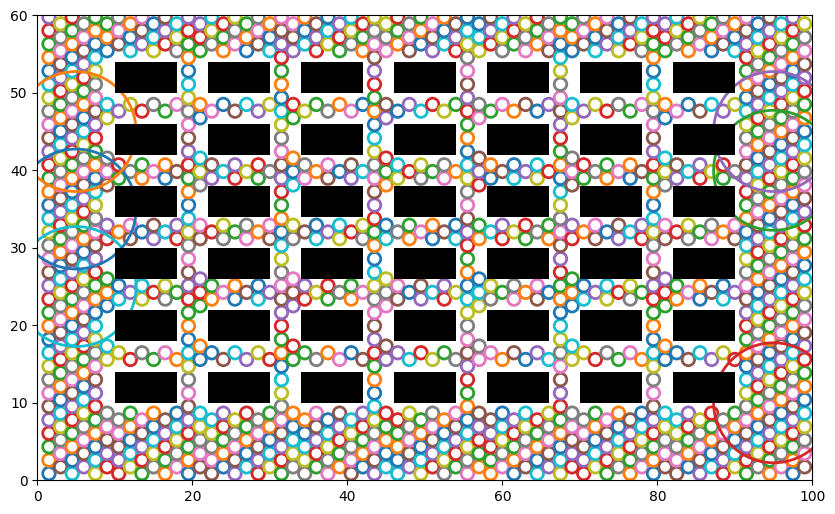

In [12]:
import pickle

from swarm_prm.solvers.utils.gaussian_prm import *
from swarm_prm.envs.map import Map, Obstacle 
from swarm_prm.envs.instance import Instance

roadmap = Map(100, 60) 
safety_radius = 2 
pos = np.array([50, 50])
coords = np.array([[20, 40, 60, 80]])

shelves = generate_map(10, 10, 8, 4, 4)

obstacles = []
for shelf in shelves:
    obstacles.append(Obstacle(None, "POLYGON", shelf))

num_samples = 100 
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 10
goal_mean = np.random.rand(2) * 10

# Agent config
num_agent = 50
agent_radius = 2
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
hex_radius = 1
TEST_CVAR = False


# Curated test instance
starts = np.array([[5, 25], [5, 35], [5, 45]])
goals = np.array([[95, 40], [95, 10], [95, 45]])

starts_weight = np.array([.3, .3, .4])
goals_weight = np.array([.3, .4, .3])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight, num_agent)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.sample_free_space(sampling_strategy="HEXAGON")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes("test_g_nodes")

with open("gaussian_prm.pkl", "wb") as f:
    pickle.dump(gaussian_prm, f)

In [13]:
import pickle
from swarm_prm.solvers.macro.teg_nx.teg_nx import TEGGraph_NX

with open("gaussian_prm.pkl", "rb") as f:
    gaussian_prm = pickle.load(f)

In [14]:
from swarm_prm.solvers.macro.teg.teg import TEGGraph
teg_graph= TEGGraph(gaussian_prm, agent_radius, target_flow=num_agent, max_timestep=500)
max_flow, flow_dict, timestep, teg = teg_graph.get_earliest_timestep()

timestep: 35 max_flow: 0
timestep: 36 max_flow: 0
timestep: 37 max_flow: 0
timestep: 38 max_flow: 0
timestep: 39 max_flow: 0
timestep: 40 max_flow: 0
timestep: 41 max_flow: 0
timestep: 42 max_flow: 0
timestep: 43 max_flow: 0
timestep: 44 max_flow: 0
timestep: 45 max_flow: 0
timestep: 46 max_flow: 0
timestep: 47 max_flow: 0
timestep: 48 max_flow: 0
timestep: 49 max_flow: 0
timestep: 50 max_flow: 0
timestep: 51 max_flow: 0
timestep: 52 max_flow: 0
timestep: 53 max_flow: 0
timestep: 54 max_flow: 0
timestep: 55 max_flow: 0
timestep: 56 max_flow: 0
timestep: 57 max_flow: 0
timestep: 58 max_flow: 0
timestep: 59 max_flow: 0
timestep: 60 max_flow: 0
timestep: 61 max_flow: 0
timestep: 62 max_flow: 0
timestep: 63 max_flow: 0
timestep: 64 max_flow: 0
timestep: 65 max_flow: 0
timestep: 66 max_flow: 0
timestep: 67 max_flow: 0
timestep: 68 max_flow: 0
timestep: 69 max_flow: 0
timestep: 70 max_flow: 0
timestep: 71 max_flow: 0
timestep: 72 max_flow: 0
timestep: 73 max_flow: 0
timestep: 74 max_flow: 0


In [15]:
print("max flow", max_flow)
print("timestep", timestep)

assert max_flow is not None, "Unable to find solution within the given timesteps"

from pprint import pprint
pprint(flow_dict)

# macro_sol = gaussian_prm.get_macro_solution(flow_dict)
# print(macro_sol)
simple_paths, gaussian_paths = gaussian_prm.get_solution(flow_dict, timestep, num_agent)
with open("simple_paths.pkl", "wb") as f:
    pickle.dump(simple_paths, f)

max flow None
timestep None


AssertionError: Unable to find solution within the given timesteps

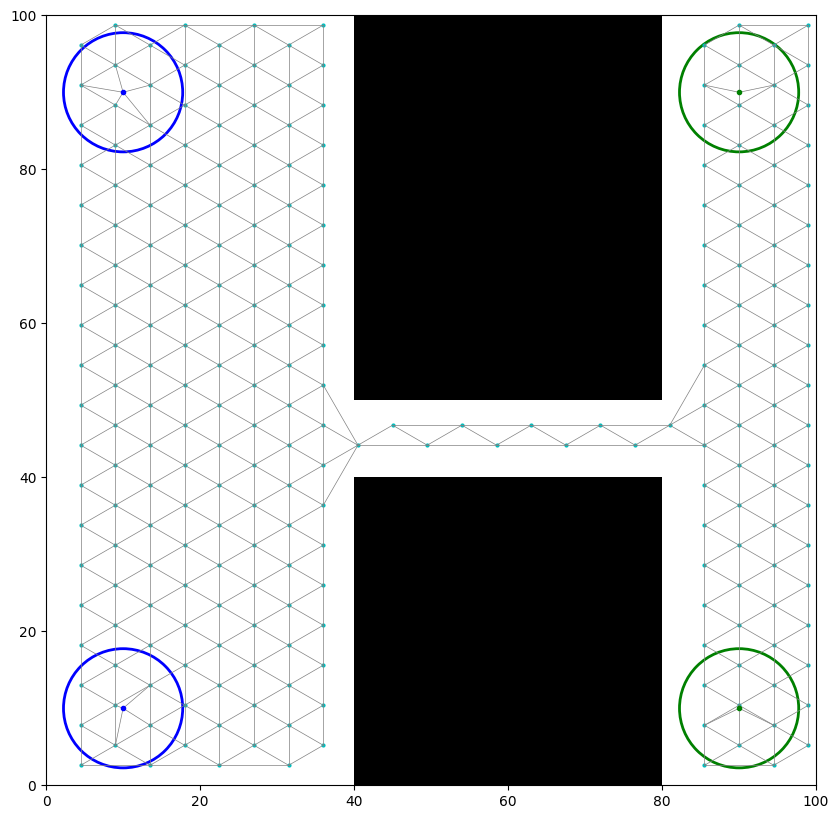

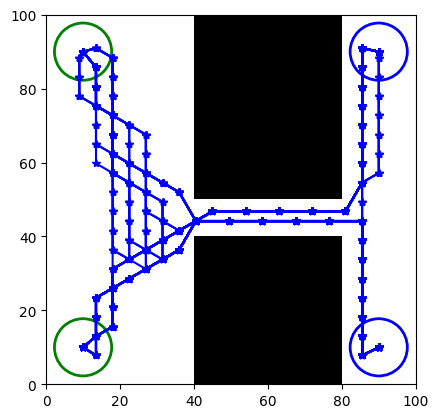

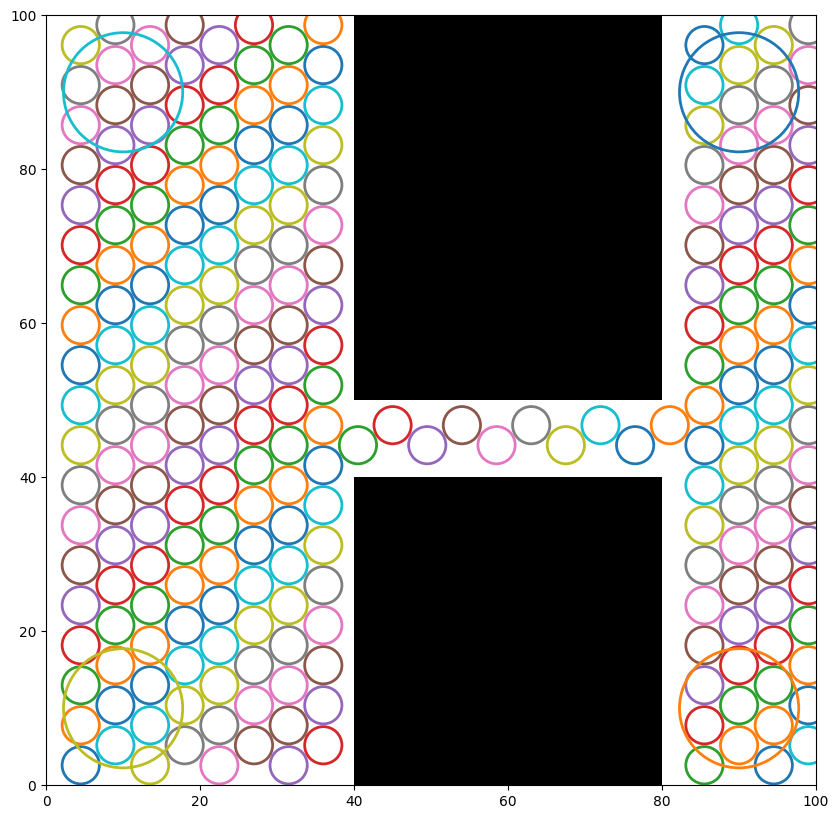

In [13]:
gaussian_prm.visualize_g_nodes()
gaussian_prm.visualize_roadmap()
fig, ax = instance.visualize()

# apf_solver.animate_solution(fig, ax)
for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 

## APF

In [14]:
import pickle
from matplotlib import pyplot as plt
from swarm_prm.solvers.micro.apf.apf_single_step import APFSingleStepSolver

with open("simple_paths.pkl", "rb") as f:
    simple_paths = pickle.load(f)

agent_radius = 1e-10
apf_solver = APFSingleStepSolver(roadmap, simple_paths, agent_radius, timestep, 
                                 step_size=0.1, max_timestep_iter=10, 
                                 ordering_strategy="GEOMETRY", 
                                 attract_coeff=0.3, repel_coeff=0.4, agent_repel_coeff=10,
                                 obs_thresh=1, reach_dist=5)
apf_path = apf_solver.get_solution()

fig, ax = instance.visualize()

# apf_solver.animate_solution(fig, ax)
for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 
cmap = plt.get_cmap("tab10")
# 
for i, path in enumerate(apf_path):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '--', label='Path', color=cmap(i%10))

print(len(apf_path[0]))

Found solution
2277


In [15]:
def animate_solution(fig, ax, speed):
    """
        Visualize solution trajectory provided instance
    """
    
    agents = []
    def init():
        for agent in agents:
            agent.remove()
        agents.clear()
        return []

    def update(frame):
        idx = frame * speed
        for agent in agents:
            agent.remove()
        agents.clear()
        cmap = plt.get_cmap("tab10")
        locs = [traj[idx] for traj in apf_path]
        for i, loc in enumerate(locs):
            agent = ax.add_patch(Circle(loc, radius=1, color=cmap(i%10)))
            agents.append(agent)
        return agents

    anim = FuncAnimation(fig, update, frames=len(apf_path[0]) // speed, 
                         init_func=init, blit=True, interval=100)
    anim.save("apf_solution.gif", writer='pillow', fps=6)

fig, ax = instance.visualize()
animate_solution(fig, ax, 30)